## TODOS

I think this is mostly built out, BUT we'll need to think about how to implement this in the batched version.

## Setting up the environment

In [46]:
pacman::p_load(
  tidyverse,  # Data manipulation and visualization
  glue,       # String interpolation
  here,       # File path manipulation
  MixedPsy,   # Mixed factorial design analysis
  lmerTest,   # ANOVA for linear mixed effects models
  performance,# model testing
  afex,       # Factorial experiment analysis
  ggtext,     # Formatted text in ggplot2
  ggrain,     # Sediment grain size analysis
  ggpp,       # Enhanced ggplot2 features
  sdamr       # Marine research data analysis
)

#----- custom plot theme

text_size = 14
strip_bg_color = "grey20"
strip_text_color = "white"


# custom APA plot
theme_apa <- function(){
  theme(
    plot.title = element_markdown(size = text_size), # Adjust the size as needed
    #legend.position = "right",
    legend.text = element_markdown(size = text_size),
    legend.title = element_text(face="bold", size = text_size + 2),
    legend.key = element_blank(),
    plot.caption = element_text(hjust = 0),
    axis.text.x = element_text(size = text_size),
    axis.text.y = element_text(size = text_size),
    axis.title.x = element_markdown(size = text_size+2, face = "bold"),  # Bolds x title
    axis.title.y = element_markdown(size = text_size+2, face = "bold"),  # Bolds y title
    axis.title.x.top = element_markdown(size = text_size+2, face = "bold"),  # Bolds x title
    axis.title.y.right = element_markdown(size = text_size+2, face = "bold"),  # Bolds y title
    strip.text = element_text(size = text_size+2, face = "bold", color = strip_text_color),
    strip.background = element_rect(fill = strip_bg_color, color = "black", size = 1),    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    panel.background = element_rect(fill = "white"), # Set the background color to white
    axis.line = element_line(color = "black") # prevents axes from disappearing
)}
rawdata_folder <- here("rawdata")

In [47]:
pressure_df <- read_csv(here(rawdata_folder, "combined_pressure_selection_data.csv"))

nonpressure_df <- read_csv(here(rawdata_folder, "combined_non_pressure_selection_data.csv"))

all_data_raw_df <- bind_rows(nonpressure_df, pressure_df)

DT::datatable(all_data_raw_df)

Rows: 3600 Columns: 12
-- Column specification --------------------------------------------------------
Delimiter: ","
chr  (2): group, session
dbl (10): part_num, direction_block, trial_num, ratio, choice, decision, cor...

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 3456 Columns: 12
-- Column specification --------------------------------------------------------
Delimiter: ","
chr  (2): group, session
dbl (10): part_num, direction_block, trial_num, ratio, choice, decision, cor...

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


HTML widgets cannot be represented in plain text (need html)

In [48]:
all_data_raw_df <- 
  all_data_raw_df %>%
  # split by group, then participant, then direction_block
  group_by(group, part_num, direction_block) %>%
  # perform the following within each direction_block
  mutate(starting_ratio = first(ratio),
         ending_ratio = last(ratio),
         direction = ifelse(starting_ratio > ending_ratio, 
                            # starts at 1.4 and goes to 0.6
                            "Affordance emerging", 
                            "Affordance disappearing"),
         variance= var(decision)
         ) # get the variance of the decision

In [49]:
# getting rid of zero variance as it means no change in behavior
filtered_data_raw_df <- all_data_raw_df%>%
  filter(variance > .15)  

In [50]:
response_pab_df <- 
  filtered_data_raw_df %>%
  group_by(group, part_num, direction, ratio, session) %>%
  summarise(
    total = n(), #why this total isn't 8 for each ratio for each particip?
    through = sum(decision == "0"), # I corrected this!
    around = sum(decision == "1"),
  )


response_prob_df <- 
  filtered_data_raw_df %>%
  group_by(group, part_num, direction, ratio, session) %>%
  summarise(
    choice_prob = mean(choice),
        #correct_through_prob = mean(correct_through),
        #risky_bump_prob = mean(risky_bump),
        #correct_around_prob = mean(correct_around),
        #ineficient_around_prob = mean(ineficient_around)
  )

`summarise()` has grouped output by 'group', 'part_num', 'direction', 'ratio'.
You can override using the `.groups` argument.
`summarise()` has grouped output by 'group', 'part_num', 'direction', 'ratio'.
You can override using the `.groups` argument.


## Individual example
In this example we are calculating the Perceived action boundary (PAB) of:
    - participant 109
    - in session 1

This should result in a dataframe that contains BOTH ascending and descending blocks.


In [51]:
indv_df <-
  response_pab_df %>%
  filter(
         part_num == 109,
         session == "Session 1",
         #direction == "Affordance emerging"
         )

indv_df

group,part_num,direction,ratio,session,total,through,around
<chr>,<dbl>,<chr>,<dbl>,<chr>,<int>,<int>,<int>
Nonpressure Group,109,Affordance disappearing,0.6,Session 1,4,4,0
Nonpressure Group,109,Affordance disappearing,0.7,Session 1,4,4,0
Nonpressure Group,109,Affordance disappearing,0.8,Session 1,4,4,0
Nonpressure Group,109,Affordance disappearing,0.9,Session 1,4,4,0
Nonpressure Group,109,Affordance disappearing,1.0,Session 1,4,0,4
Nonpressure Group,109,Affordance disappearing,1.1,Session 1,4,1,3
Nonpressure Group,109,Affordance disappearing,1.2,Session 1,4,0,4
Nonpressure Group,109,Affordance disappearing,1.3,Session 1,4,0,4
Nonpressure Group,109,Affordance disappearing,1.4,Session 1,4,0,4


## Modeling

When we model we'll need to create seperate models for the ascending and descending blocks.

In [52]:

indv_glm_asc <- glm(formula = cbind(through, total - through) ~ ratio,
                family = binomial(link = "probit"), data = indv_df %>% filter(direction == "Affordance emerging"))



indv_pab_asc <- data.frame(part_num = 109, direction = "Affordance emerging", pab = MixedPsy::PsychDelta(indv_glm_asc)["pse", "Estimate"])
indv_pab_asc


part_num,direction,pab
<dbl>,<chr>,<dbl>
109,Affordance emerging,1.10929


In [53]:
indv_glm_desc <- glm(formula = cbind(through, total - through) ~ ratio,
                family = binomial(link = "probit"), data = indv_df %>% filter(direction == "Affordance disappearing"))

indv_pab_desc <- data.frame(part_num = 109, direction = "Affordance disappearing", pab = MixedPsy::PsychDelta(indv_glm_desc)["pse", "Estimate"])

indv_pab_desc

part_num,direction,pab
<dbl>,<chr>,<dbl>
109,Affordance disappearing,0.9824812


## Plotting example

Likely going to have to do this by hand. To create the plot we'll need:

- The PAB for the ascending and descending blocks
- The raw data (probabilities) for the ascending and descending blocks (scatter plot of probabilities)
- The predicted probabilities for the ascending and descending blocks from the model (logistic curves)

In [54]:
# getting ratio range for the plot

min(indv_df$ratio)
max(indv_df$ratio)
ratio_range <- seq(min(indv_df$ratio), max(indv_df$ratio), by = 0.025)

[1] 0.6

[1] 1.4

In [55]:
pab_values_df <- bind_rows(indv_pab_asc, indv_pab_desc)

pab_values_df

part_num,direction,pab
<dbl>,<chr>,<dbl>
109,Affordance emerging,1.1092903
109,Affordance disappearing,0.9824812


In [56]:
# The raw data (probabilities) for the ascending and descending blocks (scatter plot of probabilities)

observed_probs_df <- indv_df %>%
  summarise(ratio = unique(ratio), prob = through/total)
  
observed_probs_df


`summarise()` has grouped output by 'group', 'part_num', 'direction'. You can
override using the `.groups` argument.


group,part_num,direction,ratio,prob
<chr>,<dbl>,<chr>,<dbl>,<dbl>
Nonpressure Group,109,Affordance disappearing,0.6,1.00
Nonpressure Group,109,Affordance disappearing,0.7,1.00
Nonpressure Group,109,Affordance disappearing,0.8,1.00
Nonpressure Group,109,Affordance disappearing,0.9,1.00
Nonpressure Group,109,Affordance disappearing,1.0,0.00
Nonpressure Group,109,Affordance disappearing,1.1,0.25
Nonpressure Group,109,Affordance disappearing,1.2,0.00
Nonpressure Group,109,Affordance disappearing,1.3,0.00
Nonpressure Group,109,Affordance disappearing,1.4,0.00


In [57]:
# The predicted probabilities for the ascending and descending blocks from the model (logistic curves)
values_asc <- predict(indv_glm_asc, newdata = data.frame(ratio = ratio_range), type = "response")
predicted_df_asc <- data.frame(ratio = ratio_range, prob = values_asc, direction = "Affordance emerging")

values_desc <- predict(indv_glm_desc, newdata = data.frame(ratio = ratio_range), type = "response")
predicted_df_desc <- data.frame(ratio = ratio_range, prob = values_desc, direction = "Affordance disappearing")

predicted_probs_df <- bind_rows(predicted_df_asc, predicted_df_desc)

predicted_probs_df


,ratio,prob,direction
,<dbl>,<dbl>,<chr>
1...1,0.600,0.99999648,Affordance emerging
2...2,0.625,0.99999031,Affordance emerging
3...3,0.650,0.99997454,Affordance emerging
4...4,0.675,0.99993614,Affordance emerging
5...5,0.700,0.99984707,Affordance emerging
6...6,0.725,0.99965024,Affordance emerging
7...7,0.750,0.99923582,Affordance emerging
8...8,0.775,0.99840455,Affordance emerging
9...9,0.800,0.99681597,Affordance emerging


## Creating the plot

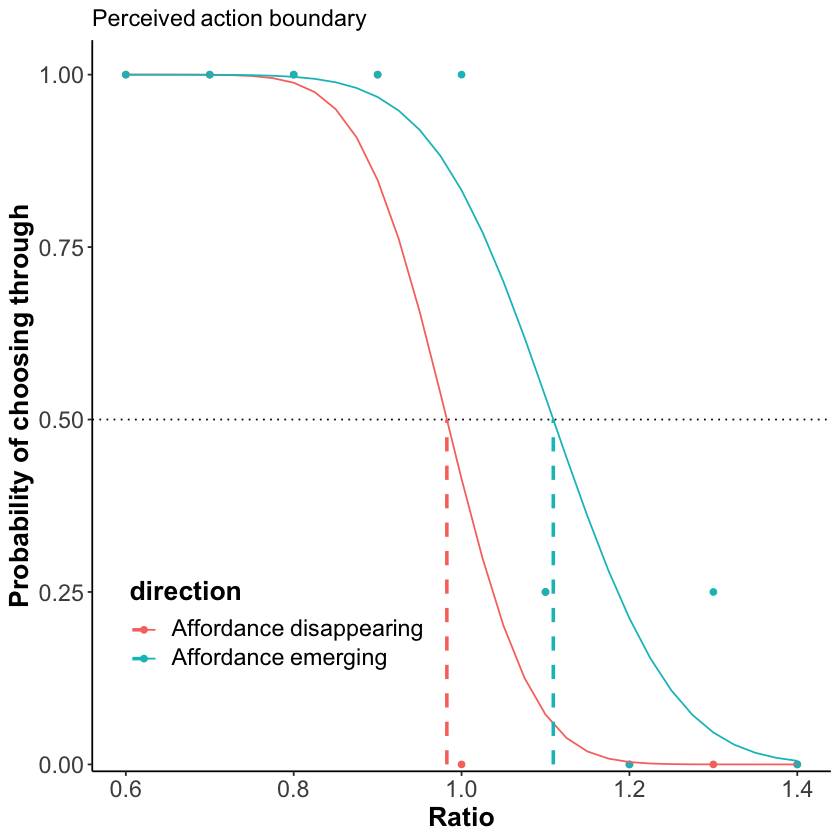

In [58]:
ggplot() + # initiate the ggplot object
  geom_point(data = observed_probs_df, aes(x = ratio, y = prob, color = direction)) + # Add scatter plot of observed probabilities
  geom_line(data = predicted_probs_df, aes(x = ratio, y = prob, color = direction)) + # Add logistic curves
  geom_hline(yintercept = 0.5, linetype = "dotted") +  # Add horizontal line at y = 0.5
  geom_segment(data = pab_values_df, 
               aes(x = pab, xend = pab, y = 0, yend = 0.5, color = direction), 
               linetype="dashed",
               size = 1) + # Add vertical lines at the PABs
  labs(title = "Perceived action boundary",
       x = "Ratio",
       y = "Probability of choosing through") + # Add axis labels
  theme(legend.position = c(0.25, 0.2)) + # Adjust the legend position
  theme_apa() + # Apply the APA theme
  scale_y_continuous(expand = expansion(mult = c(0.01, 0.05)))  # Set y-axis intercept at y = 0
  